In [4]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [5]:
source_folder = '/scratche/home/apoorv/repos/probe_kge/data/fb15k-237'
! ls {source_folder}

dataset.yaml
entity_ids.del
entity_ids.del-True-t-False.pckl
entity_strings.del
entity_strings.del-False-t-True.pckl
index-relations_per_type.pckl
index-relation_types.pckl
index-test_po_to_s.pckl
index-test_sp_to_o.pckl
index-train_po_to_s.pckl
index-train_sp_to_o.pckl
index-valid_po_to_s.pckl
index-valid_sp_to_o.pckl
MSR-LA_Data_Full Rights_FB15K-237 Knowledge Base Completion Dataset (2650).docx
README.txt
relation_ids.del
relation_ids.del-True-t-False.pckl
relation_ids.del-True-t-True.pckl
test.del
test.del-t.pckl
test.txt
test_without_unseen.del
train.del
train.del-t.pckl
train_sample.del
train.txt
valid.del
valid.del-t.pckl
valid.txt
valid_without_unseen.del


In [6]:
def readTriples(fname):
    f = open(fname)
    triples = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        triples.append(line.split('\t'))
    f.close()
    return triples

In [7]:
# load half data
data = {}
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(source_folder, split + '.txt')
    data[split] = readTriples(fname)

In [8]:
data['train'][5000]

['/m/07t3gd', '/people/profession/specialization_of', '/m/03nfmq']

In [9]:
len(data['train'])

272115

In [10]:
uniq_tails = set()
for t in data['train']:
    uniq_tails.add(t[2])
len(uniq_tails)

13379

In [11]:
relations = set()
for s in splits:
    for triple in data[s]:
        relations.add(triple[1])

In [12]:
len(relations)

237

In [13]:
relations

{'/american_football/football_team/current_roster./sports/sports_team_roster/position',
 '/award/award_category/category_of',
 '/award/award_category/disciplines_or_subjects',
 '/award/award_category/nominees./award/award_nomination/nominated_for',
 '/award/award_category/winners./award/award_honor/award_winner',
 '/award/award_category/winners./award/award_honor/ceremony',
 '/award/award_ceremony/awards_presented./award/award_honor/award_winner',
 '/award/award_ceremony/awards_presented./award/award_honor/honored_for',
 '/award/award_nominated_work/award_nominations./award/award_nomination/nominated_for',
 '/award/award_nominee/award_nominations./award/award_nomination/award',
 '/award/award_nominee/award_nominations./award/award_nomination/award_nominee',
 '/award/award_nominee/award_nominations./award/award_nomination/nominated_for',
 '/award/award_winner/awards_won./award/award_honor/award_winner',
 '/award/award_winning_work/awards_won./award/award_honor/award',
 '/award/award_win

In [31]:
import pickle
from unidecode import unidecode
relation_map = {}
fname = '/scratche/home/apoorv/freebase/relation_names_from_google_cwq.pickle'
relation_names_from_google_cwq = pickle.load(open(fname, 'rb'))
fname = '/scratche/home/apoorv/freebase/relation_names_from_google.pickle'
relation_names_from_google = pickle.load(open(fname, 'rb'))

for k, v in relation_names_from_google_cwq.items():
    relation_names_from_google[k] = v
# for rel in relations:
#     rel_processed = relation_names_from_google[rel]
# #     rel_processed = unidecode(rel_processed)
# #     rel_processed = rel_processed.replace('|', ',')
# #     rel_processed = rel_processed.lower()
#     if rel_processed == '':
#         print(rel)
#     relation_map[rel] = rel_processed

In [32]:
relation_names_from_google

{'book.editorial_tenure.periodical': 'Periodical',
 'sports.sports_award.award_winner': 'Award Winner',
 'film.film.edited_by': 'Edited by',
 'people.ethnicity.geographic_distribution': 'Geographic distribution',
 'tv.tv_series_season.from': 'From',
 'location.country.form_of_government': 'Form of Government',
 'architecture.building_function.buildings': 'Buildings',
 'fictional_universe.sibling_relationship_of_fictional_characters.siblings': 'Siblings',
 'base.schemastaging.non_profit_extra.classification': 'Classification',
 'religion.religion.notable_figures': 'Notable Figures',
 'symbols.namesake.named_after': 'Named after',
 'american_football.football_historical_coach_position.coach': 'Coach',
 'film.music_contributor.film': 'Film music credits',
 'book.newspaper.owner': 'Owner',
 'language.human_language.dialects': 'Dialects',
 'chemistry.element_discoverer.discovered': 'Discovered',
 'user.rcheramy.default_domain.hockey_team.head_coach': 'Head Coach',
 'business.consumer_compan

In [33]:
def slashToDotRelation(rel):
    rel = rel[1:]
    rel = rel.replace('.', '')
    rel = rel.replace('/', '.')
    return rel

In [34]:
count = 0
for triple in data['train']:
    rel = slashToDotRelation(triple[1])
    if rel in relation_names_from_google:
        count += 1
count, len(data['train'])

(66923, 272115)

In [58]:
count = 0
relations_names_needed = []
for rel in relations:
    rel_processed = slashToDotRelation(rel)
    if rel_processed in relation_names_from_google:
        count += 1
    else:
        relations_names_needed.append(rel)
#         print(rel)
count

63

In [71]:
# def getLastPart(rel):
#     last_part = ', '.join(rel.split('.')[-2:])
#     last_part = last_part.replace('_', ' ')
#     last_part = last_part.capitalize()
#     return last_part

def getLastPart(rel):
    last_part = ', '.join(rel.replace('.', '').split('/')[-2:])
    last_part = last_part.replace('_', ' ')
    last_part = last_part.capitalize()
    return last_part
#     return rel.split('/')[-1]

In [77]:
name_rels_dict = {}
rels_set = set()
conflict_last_parts = set()
conflict_rels = set()
for rel in relations_names_needed:
    last_part = getLastPart(rel)#rel.split('.')[-1]
    if last_part in rels_set:
#         print(name_rels_dict[last_part], '|||', rel)
        conflict_last_parts.add(last_part)
        conflict_rels.add(rel)
    else:
        rels_set.add(last_part)
        name_rels_dict[last_part] = rel

In [78]:
len(conflict_last_parts)

25

In [74]:
count = 0
rel_count_dict = {}
for t in data['train']:
    rel = t[1]
    if rel in conflict_rels:
        count += 1
        if rel in rel_count_dict:
            rel_count_dict[rel] += 1
        else:
            rel_count_dict[rel] = 1
count, len(data['train'])

(61337, 272115)

In [79]:
rel2name = {}
for rel in relations:
    rel_processed = slashToDotRelation(rel)
    if rel_processed in relation_names_from_google:
        name = relation_names_from_google[rel_processed]
    else:
        name = getLastPart(rel)
    rel2name[rel] = name

In [81]:
len(rel2name)

237

In [82]:
description_file = 'data/fb15k237_2/entity2textlong.txt'
f = open(description_file)
ent2desc = {}
for line in f:
    line = line.split('\t')
    ent2desc[line[0]] = line[1]
f.close()
len(ent2desc)

14904

In [180]:
only_name_file  = 'data/fb15k237_2/entity2text.txt'
f = open(only_name_file)
ent2onlyname = {}
for line in f:
    line = line.rstrip().split('\t')
    ent2onlyname[line[0]] = line[1]
f.close()
len(ent2onlyname)

14951

In [203]:
descriptions = list(ent2desc.values())
def shortenDescription(desc):
    desc = desc.split('.')[0]
    desc = desc.split('\n')[0]
    desc = desc.split('\t')[0]
    if len(desc) > 100:
        desc = desc.split(';')[0]
        desc = desc.split(':')[0]
    return desc

def removeBlankSpace(s):
    s = s.replace('\t', ' ')
    s = s.replace('\n', ' ')
    return s

In [204]:
import random
import unicodedata
ent2name = {}
ent_names_set = set()
for eid, description in ent2desc.items():
    description = unicodedata.normalize('NFKC', description)
    short_desc = shortenDescription(description)
    short_desc = removeBlankSpace(short_desc)
    description = removeBlankSpace(description)
    name = ""
    if short_desc not in ent_names_set:
        name = short_desc
    else:
        if description[:120] not in ent_names_set:
            name = description[:120]
        else:
            name = short_desc + ' ' + str(random.randint(0,10))
    ent_names_set.add(name)
    ent2name[eid] = name

In [205]:
for eid, onlyname in ent2onlyname.items():
    if eid not in ent2name:
        ent2name[eid] = onlyname

In [206]:
len(ent2name), len(set(ent2name.values()))

(14951, 14951)

In [207]:
from transformers import T5TokenizerFast
tokenizer = T5TokenizerFast.from_pretrained('t5-small')

In [208]:
from tqdm.notebook import tqdm
lengths = []
for id, name in tqdm(ent2name.items()):
    x = tokenizer(name)
    lengths.append(len(x['input_ids']))

Text(0.5, 0, 'Tokenized lengths')

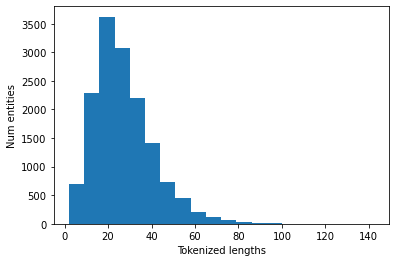

In [209]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=20) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [210]:
count = 0
for l in lengths:
    if l < 80:
        count += 1
count, len(lengths)

(14882, 14951)

In [211]:
dest_folder = '/scratche/home/apoorv/transformer-kgc/data/fb15k237_2'

In [212]:
def triple2text(t):
    global rel2name, ent2name
    rel = rel2name[t[1]]
    out = [ent2name[t[0]], rel, ent2name[t[2]]]
    return out

In [213]:
def mapTriple(t):
    out = triple2text(t)
    return out

In [214]:
for id in range(10):
    print(mapTriple(data['train'][id]))

['The Dominican Republic is a nation on the island of Hispaniola, part of the Greater Antilles archipelago in the Caribbean region', 'Form of Government', 'A republic is a form of government in which power is held by the people and representatives they elect, and affairs of state are a \\"public matter\\", rather than privately accommodated']
["Mighty Morphin Power Rangers is an American live action children's television series that premiered on August 28, 1993, on the Fox Kids weekday afternoon block", 'Regular tv appearance, actor', 'Wendee Lee is an American voice actress']
['Drama in entertainment media is a genre involved usually with in the depiction of realistic characters and emotional themes', 'Titles', 'American History X is a 1998 American drama film directed by Tony Kaye and written by David McKenna']
['Mayte Michelle Rodriguez, simply credited as Michelle Rodriguez, is an American actress, screenwriter and disc jockey', 'Award honor, award winner', 'Naveen William Sidney A

In [215]:
len(data['train'])

272115

In [216]:
out_folder = dest_folder
splits = ['train', 'test', 'valid']

count = 0
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in tqdm(triples):
        
        t = mapTriple(t)
        # only save those that DO NOT start with m. or g.
        # we can do that since aim is KGQA not KGC
        head, relation, tail = t
        input = 'predict tail: {0} | {1}'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1}'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [217]:
count

0

In [218]:
entity_names = set()
for key, value in ent2name.items():
#     if key.startswith('Q'):
    entity_names.add(value)
len(entity_names)

14951

In [219]:
for e in entity_names:
    if 'Fred Quimby' in e:
        print(e)

Fred Quimby


In [220]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = entity_names
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [221]:
# webqsp qa 
# def readQALines(fname):
#     f = open(fname)
#     questions = []
#     for line in f:
#         line = line.strip().split('\t')
#         q = line[0]
#         lhs = q.split('[')[0]
#         rhs = q.split(']')[1]
#         only_question = lhs + 'NE' + rhs
#         only_question = normalizeEntity(only_question)
# #         q = q.replace('[', '')
# #         q = q.replace(']', '')
# #         q = normalizeEntity(q)
#         questions.append(only_question)
#     return questions
        
# def writeLines(lines, fname):
#     f = open(fname, 'w')
#     for line in lines:
#         f.write(line + '\n')


In [222]:
fname = 'data/fb15k237_2/train.txt'
f = open(fname)
for line in f:
    line = line.rstrip().split('\t')
    if len(line) != 2:
        print(line)

'what character did natalie portman play in star wars NE'

In [81]:
# fname = 'data/MetaQA/full_qa.txt'
# questions = readQALines(fname)
# questions = list(set(questions))

In [82]:
# fname = 'data/MetaQA/only_questions_text.txt'
# writeLines(questions, fname)

In [138]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/fbwq_half/train.txt', 
                                    model_prefix='fbwq_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['predict',
#                                                     'head',
#                                                     'tail',
#                                                     '|'],
#                                     normalization_rule_name='identity',
                              )

In [139]:
# sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
sp = spm.SentencePieceProcessor(model_file='fbwq_with_pad.model')

In [38]:
# sp['Obama']

0

In [151]:
sp.decode(sp.encode('how old'))

'how old'

In [192]:
sp.encode('<pad>')

[5, 0, 12497, 0]

In [195]:
sp['</s>']

2

In [193]:
sp.id_to_piece(3)

'<pad>'

In [176]:
lengths = []
count = 0
for e in tqdm(ents_uniq):
    encoded = sp.encode(e)
    l = len(encoded)
    if l > 500:
        print(e,l)
        l = 20
        count += 1
    lengths.append(l)
count

100%|██████████| 1712213/1712213 [00:18<00:00, 91029.72it/s] 


0

Text(0.5, 0, 'Tokenized lengths')

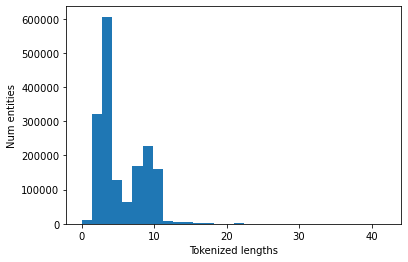

In [177]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [190]:
lengths = []
count = 0
for e in tqdm(relations):
    encoded = sp.encode(relation_map[e])
    l = len(encoded)
    if l > 10:
        print(relation_map[e])
        count +=1
    lengths.append(l)
count

100%|██████████| 1068/1068 [00:00<00:00, 41292.34it/s]

astronomical objects discovered
astronomical objects discovered reverse
sewage treatment plant
sewage treatment plant reverse
infidelity perpetrator reverse
substance abuse reverse
lifetime batting statistics reverse
sponsored by reverse
substance abuse problems reverse
appears in these fictional universes reverse
jurisdiction of office reverse
body this is a component of reverse
politicians in this party reverse
websites owned reverse
tropical cyclone season reverse
olympics hosted reverse
types of places of worship reverse
athletic performances reverse
mode of transportation reverse
appeared in tv episodes reverse
episodes appeared in reverse


21

Text(0.5, 0, 'Tokenized lengths')

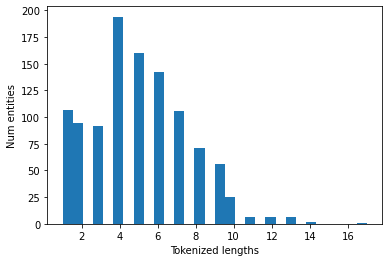

In [186]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [191]:
sp.encode('plays for')

[167, 10, 96]

In [104]:
len(uniq_ent_map)

1880592

In [143]:
def replaceEntities(line, aliases_dict):
    line = line.strip().split('\t')
    q = line[0]
    # sometimes no answer
    if len(line) > 1:
        answers= line[1].split('|')
    else:
        answers = []    
    lhs = q.split('[')[0]
    rhs = q.split(']')[1]
    head_id = q.split('[')[1].split(']')[0]
    if head_id in aliases_dict:
        head_text = aliases_dict[head_id]
    else:
        head_text = head_id
        print(head_text + ' not found')
    answers_text = []
    for a in answers:
        if a in aliases_dict:
            answers_text.append(aliases_dict[a])
        else:
            answers_text.append(a)
    answers_string = '|'.join(answers_text)
    
    out = '{lhs}[{head}]{rhs}\t{ans}'.format(
        lhs=lhs,
        rhs=rhs,
        head = head_text,
        ans = answers_string
    )
    return out
        
def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        lines.append(line.rstrip())
    f.close()
    return lines

def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [137]:
# need to make qa data as well, since entity aliases need to be used
# and not just entity ids as answers
fname = '/scratche/home/apoorv/EmbedKGQA/data/QA_data/WebQuestionsSP/qa_test_webqsp_fixed.txt'
questions = readLines(fname)


In [138]:
questions[1]

'what did james k polk do before he was president [m.042f1]\tm.02_bcst|m.04x_n9q|m.0cgqx'

In [144]:
lines_with_entities = [replaceEntities(q, uniq_ent_map) for q in questions]

m.02vkmj9 not found


In [145]:
len(lines_with_entities)

1639

In [146]:
lines_with_entities[:10]

['what does jamaican people speak [Jamaica 1]\tJamaican English|Jamaican Creole English Langua|Jamaican English',
 'what did james k polk do before he was president [James K. Polk]\tUnited States Representative|Governor of Tennessee|Speaker of the United States H',
 'who plays ken barlow in coronation street [Coronation Street]\tWilliam Roache',
 'where is jamarcus russell from [JaMarcus Russell]\tMobile 0',
 'where was george washington carver from [George Washington Carver]\tDiamond 8',
 'what else did ben franklin invent [Benjamin Franklin]\tLightning rod|Bifocals|Glass harmonica|Franklin stove',
 'who was richard nixon married to [Richard Nixon]\tPat Nixon',
 'who is governor of ohio 2011 [Ohio 2]\tJohn Kasich|Return J. Meigs, Jr.|Ted Strickland',
 'who was vice president after kennedy died [John F. Kennedy 0]\tLyndon B. Johnson 1',
 'where is the fukushima daiichi nuclear plant located [Fukushima Daiichi Nuclear Powe]\tJapan 1|Okuma']

In [148]:
fname = 'data/fbwq_half/qa_valid_1hop.txt'
writeLines(lines_with_entities, fname)